In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import random
import cv2
import os
import PIL
import pathlib
import splitfolders

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.efficientnet import EfficientNetB3
from keras.applications.inception_v3 import InceptionV3

In [3]:
batch_size = 64
img_height, img_width = 224, 224
input_shape = (img_height, img_width, 3)
classes = ['safe driving', 'texting-right', 'calling-right', 'texting-left', 'calling-left', 'operating radio', 'drinking', 'reaching behind']

In [7]:
train_datagen = ImageDataGenerator(
    shear_range = 0.2, 
    zoom_range = 0.2)

val_datagen = ImageDataGenerator()

train_ds = train_datagen.flow_from_directory(
    '../Distraction Detection/datasets/finalds_splitted/train',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    seed = 123,
    class_mode='categorical')

val_ds = val_datagen.flow_from_directory(
    '../Distraction Detection/datasets/finalds_splitted/val',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    seed = 123,
    class_mode='categorical',
    shuffle=False)

test_ds = val_datagen.flow_from_directory(
    '../Distraction Detection/datasets/finalds_splitted/test',
    target_size = (img_height, img_width),
    batch_size = batch_size,
    seed = 123,
    class_mode='categorical',
    shuffle=False)

test_ds.class_indices = ['safe driving', 'texting-right', 'calling-right', 'texting-left', 'calling-left', 'operating radio', 'drinking', 'reaching behind']

Found 18568 images belonging to 8 classes.
Found 2325 images belonging to 8 classes.
Found 2332 images belonging to 8 classes.


In [8]:
model = tf.keras.models.load_model('model_efficientnetv2.hdf5')

In [9]:
score = model.evaluate(test_ds, verbose=1)
print(f'Loss: {score[0]}, Accuracy: {score[1]*100}')

37/37 [==============================] - 9s 175ms/step - loss: 0.0057 - accuracy: 0.9987
Loss: 0.005723773501813412, Accuracy: 99.87135529518127


In [10]:
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict(test_ds)

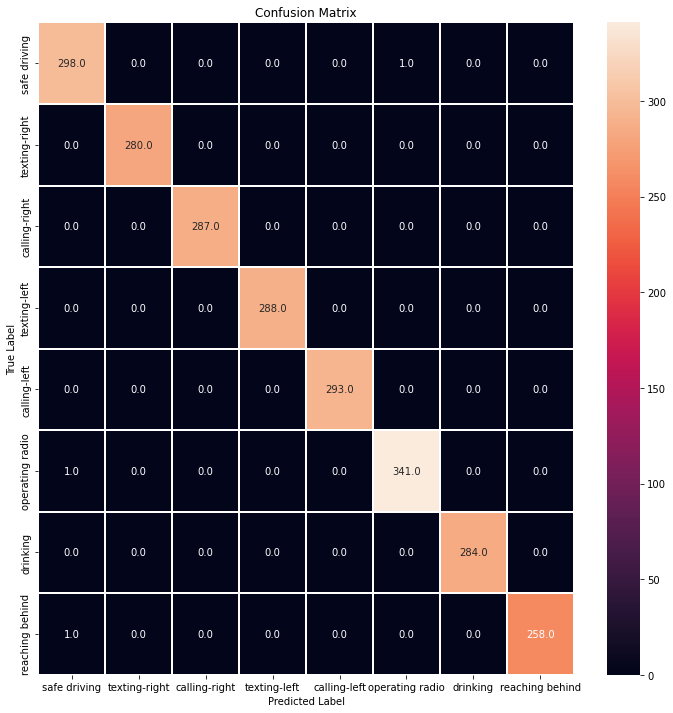

In [13]:
y_pred = np.argmax(Y_pred, axis=1)
confusion_mtx = confusion_matrix(y_pred, test_ds.classes)
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(confusion_mtx, annot=True, 
            linewidths=0.01,
            linecolor="white", 
            fmt= '.1f',ax=ax,)
sns.color_palette("rocket", as_cmap=True)

plt.xlabel("Predicted Label")
plt.ylabel("True Label")
ax.xaxis.set_ticklabels(test_ds.class_indices)
ax.yaxis.set_ticklabels(classes)
plt.title("Confusion Matrix")
plt.show()

In [14]:
report = classification_report(test_ds.classes, y_pred, target_names=classes, output_dict=True)
df = pd.DataFrame(report).transpose()
df

,precision,recall,f1-score,support
safe driving,0.996656,0.993333,0.994992,300.000000
texting-right,1.000000,1.000000,1.000000,280.000000
calling-right,1.000000,1.000000,1.000000,287.000000
texting-left,1.000000,1.000000,1.000000,288.000000
calling-left,1.000000,1.000000,1.000000,293.000000
operating radio,0.997076,0.997076,0.997076,342.000000
drinking,1.000000,1.000000,1.000000,284.000000
reaching behind,0.996139,1.000000,0.998066,258.000000
accuracy,0.998714,0.998714,0.998714,0.998714
macro avg,0.998734,0.998801,0.998767,2332.000000


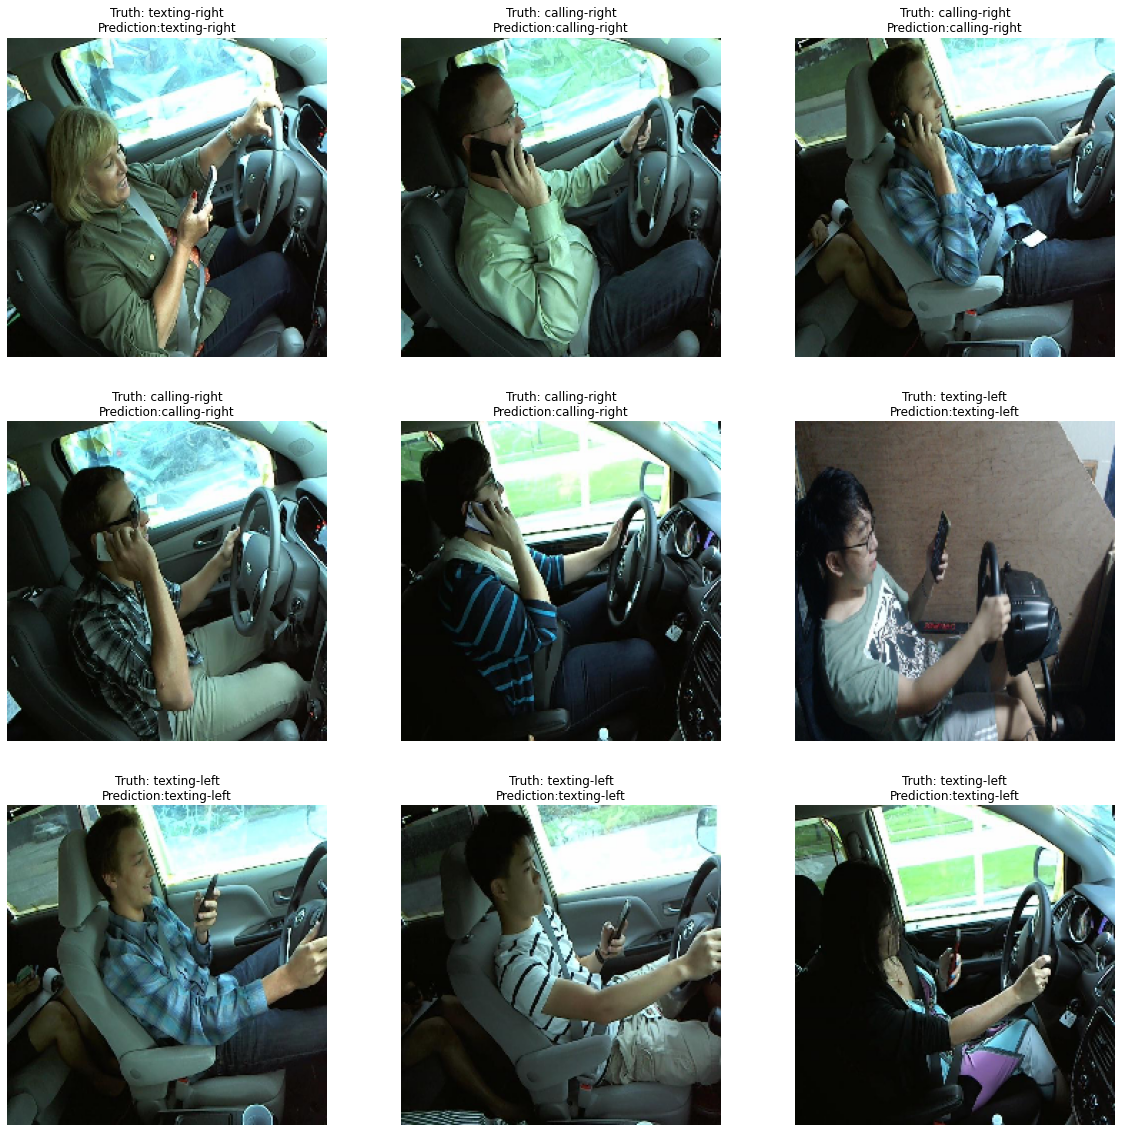

In [16]:
plt.figure(figsize=(20, 20))
for i in range(9):
    x, label= test_ds.next()
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i].astype('uint8'))
    result = np.where(label[i]==1)
    predict = model(tf.expand_dims(x[i], 0))
    score = tf.nn.softmax(predict[0])
    score_label = classes[np.argmax(score)]
    plt.title(f'Truth: {classes[result[0][0]]}\nPrediction:{score_label}')
    plt.axis(False)

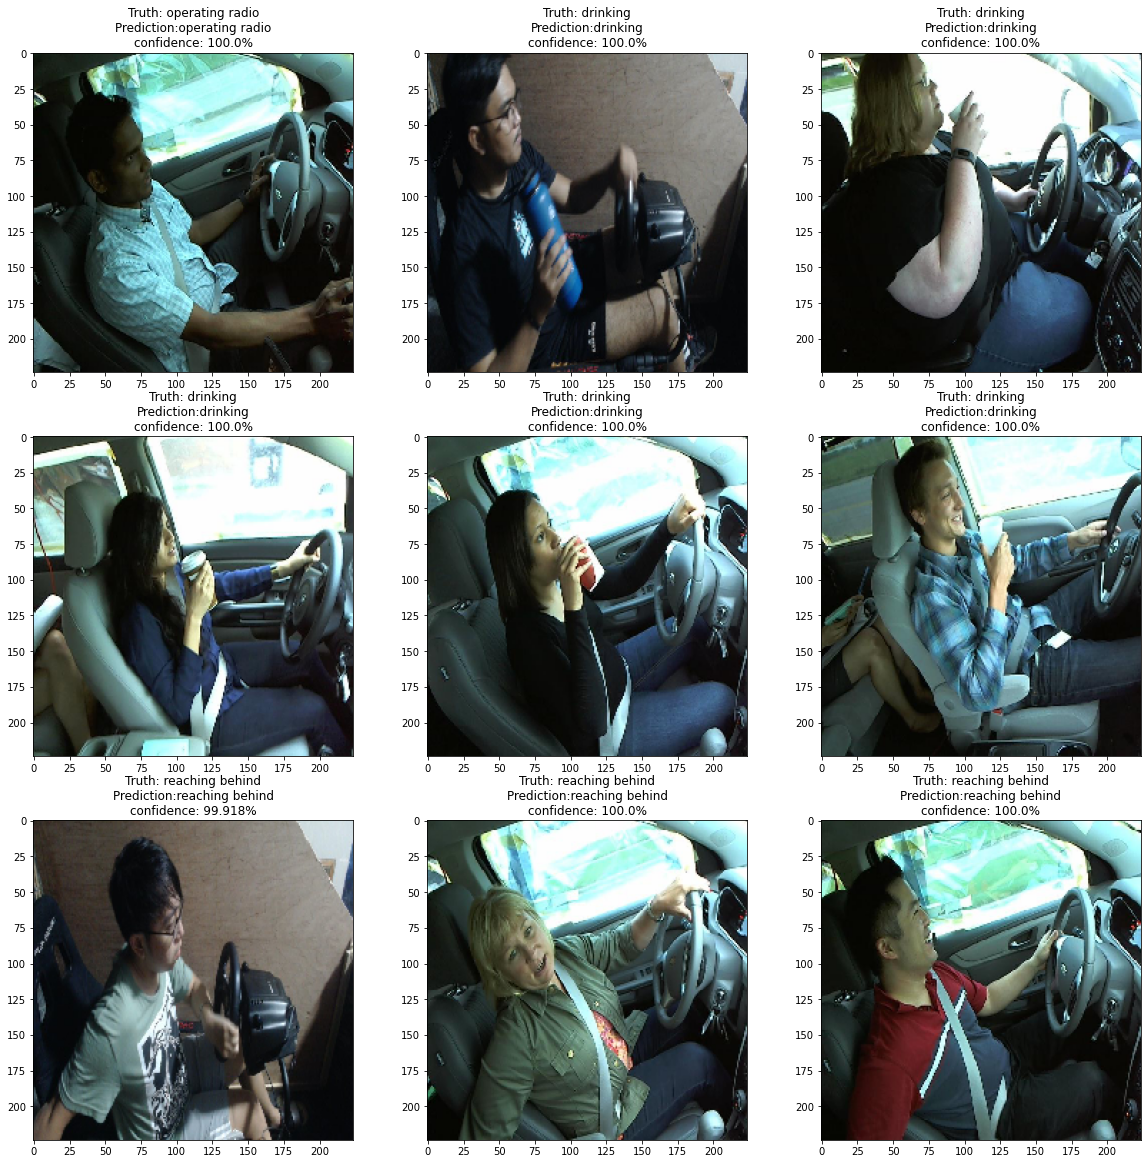

In [13]:
plt.figure(figsize=(20, 20))
for i in range(9):
    x, label= test_ds.next()
    plt.subplot(3, 3, i+1)
    plt.imshow(x[i].astype('uint8'))
    result = np.where(label[i]==1)
    normalized = tf.expand_dims(x[i], 0)
    predict = model.predict(normalized)
    score = tf.nn.softmax(predict[0])
    index = np.argmax(score)
    score_label = classes[index]
    confidence_score = (predict[0][index])*100
    confidence_score = round(confidence_score, 3)
    plt.title(f'Truth: {classes[result[0][0]]}\nPrediction:{score_label}\nconfidence: {confidence_score}%')